### Notebook to test the Wine Contest

Carlos H Grohmann
2022

In [2]:
# imports
import sys,os
from IPython.display import clear_output, display
import qgrid

import pandas as pd
import numpy as np
from scipy.special import ndtri
import seaborn as sns

# aux func
def qshow(df):
    '''show df witrh qgrid and predefined options'''
    grd = qgrid.show_grid(df, grid_options={'forceFitColumns': False, 'defaultColumnWidth': 100})
    return grd


#### I can't get the interactive file selection to work on Binder, so we'll have to go manual.   
#### I'll print a list of the available CSV files and you decide which ones you want.

### Open CSV file(s)

In [5]:
csv_dir = 'csv_files'
csv_files = os.listdir(csv_dir)
print('Available CSV files: \n')
for f in csv_files:
    print(f)

Available CSV files: 

italy_Elevation_moments.csv
italy_Elevation_moments_diff.csv
italy_Elev_diff_stats.csv
italy_Pits_and_peaks.csv
italy_Slope_diff_stats.csv
italy_Slope_moments.csv
italy_Slope_moments_diff.csv
la_palma_Elevation_moments.csv
la_palma_Elevation_moments_diff.csv
la_palma_Elev_diff_stats.csv
la_palma_Geodetic_control_stats.csv
la_palma_ICESat_best_diff_stats.csv
la_palma_Pits_and_peaks.csv
la_palma_Slope_diff_stats.csv
la_palma_Slope_moments.csv
la_palma_Slope_moments_diff.csv
oxford1_Elevation_moments.csv
oxford1_Elevation_moments_diff.csv
oxford1_Elev_diff_stats.csv
oxford1_Pits_and_peaks.csv
oxford1_Slope_diff_stats.csv
oxford1_Slope_moments.csv
oxford1_Slope_moments_diff.csv
uruguay_1_Elevation_moments.csv
uruguay_1_Elevation_moments_diff.csv
uruguay_1_Elev_diff_stats.csv
uruguay_1_Pits_and_peaks.csv
uruguay_1_Slope_diff_stats.csv
uruguay_1_Slope_moments.csv
uruguay_1_Slope_moments_diff.csv


In [6]:
# define here a listo of the files to be opened:

selected_csv_files = ['italy_Elevation_moments.csv','la_palma_Elevation_moments.csv']

In [7]:
# make dataframes from csv files and append all to a single one
df_csv = pd.DataFrame()
for f in selected_csv_files:
    f = os.path.join(csv_dir,f)
    df = pd.read_csv(f, sep=',',engine='python',comment='#',quotechar='"')
    df_csv = pd.concat([df_csv,df],sort=False)
    
# get lists with DEMs names and criteria
crit_cols = list(df_csv.columns)[5:]
crit_cols_rank = [i+'_rank' for i in crit_cols]
crit_cols_rank_sq = [i+'_rank_sq' for i in crit_cols]
dem_cols = list(df_csv['DEM'].unique())


# rank values in df
df_ranks = pd.concat([df_csv, df_csv.rank(method='average', ascending=True, axis=1).add_suffix('_rank')], axis=1)
for col in crit_cols:
    df_ranks[col+'_rank_sq'] = df_ranks[col+'_rank']**2


print(f'DEMs being compared: {dem_cols}\n')
print(f'Criteria: {crit_cols}')

# show table 
qshow(df_ranks)

DEMs being compared: ['md_italy_1sec_point', 'md_italy_1sec_area', 'COP', 'SRTM_egm2008', 'ALOS_egm2008', 'NASA_egm2008', 'ASTER_egm2008', 'FABDEM', 'md_dtm-2m_1sec_point', 'md_dtm-2m_1sec_area']

Criteria: ['GRID_FULL', 'MIN', 'Max', 'Mean', 'STD_DEV', 'SKEWNESS', 'KURTOSIS', 'MEDIAN', 'N']


QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

### First to compute: Friedman Test Statistic's

*Null hypothesis: there exist no statistically significant difference among the DEMs*  

Friedman Test using formula from:https://jimgrange.wordpress.com/2014/05/29/friedmans-test-with-tied-data/ 

where n is the number of observations per condition, k is the number of conditions, and Ri is the sum of the ith column (condition).

Friedman Statistic's  
n(k-1)[sum Ri_sq/n - cf] / sum rij_sq - cf  
cf = (1/4)nk(k+1)**2

In [8]:
n = len(dem_cols) # number of DEMs
k = len(crit_cols) # number of CRITERIA
cf = 1/4*n*k*((k+1)**2)

sum_ranks = df_ranks[crit_cols_rank].sum().sum()
sum_ranks_sq = df_ranks[crit_cols_rank_sq].sum().sum()

chi_r =( (n * (k-1)) * (sum_ranks_sq/n - cf) )/ (sum_ranks - cf)

print(f'n = {n} (number of DEMs)')
print(f'k = {k} (number of Criteria)')
print(f'cf = {cf}')
print(f'sum of ranks = {sum_ranks}')
print(f'sum of ranks squared = {sum_ranks_sq}')
print(f'chi_r = {chi_r:4.3f}')

n = 10 (number of DEMs)
k = 9 (number of Criteria)
cf = 2250.0
sum of ranks = 5220.0
sum of ranks squared = 53765.5
chi_r = 84.217


#### Get critical value from tables

Given your k value, look for the proper table at:   http://hdl.handle.net/20.500.11968/4208  
From the table, look at the row at your N and read the entry at your preferred confidence level  
if chi_r>chi_crit, we must reject the null hipothesis and go the the Post-Hoc analysis below  
(Reject means that we cannot accept that all DEM are equivalent)  
If chi_r<chi_crit, we cannot disprove the null hipothesis at the given CL and the test finishes

In [9]:
CL = 0.05

tables_dir = 'Friedmans_tables'
# os.listdir(tables_dir)
table_needed = f'k_{k}.txt'
# print(f'Table needed: {table_needed}')
df_crit = pd.read_csv(os.path.join(tables_dir,table_needed),sep=';')
df_crit = df_crit.iloc[: , :-1] # drop last column as it is empty
df_crit

# find chi_crit in table
n_alpha = f'N={n}' 
idx = df_crit.loc[df_crit['alpha'] == n_alpha].index[0]
col = f'{CL:05.3f}'

# try to get the value, if not possible, use last row IS THIS CORRECT??
try:
    chi_crit = df_crit.at[idx, col]
except:
    idx = df_crit.index[-1]
    chi_crit = df_crit.at[idx, col]
    
print(f'For k={k}, CL={CL}, and N={n}, the critical value to compare is chi_crit={chi_crit}')
print()
print(f'chi_r: {chi_r:04.3f}')
print(f'chi_crit: {chi_crit}\n')

if chi_r > chi_crit:
    print('Yay!! We can reject the null hipothesis and go to the Post-Hoc analysis!!')
else:
    print('Oh, no! We  we cannot disprove the null hipothesis at the given CL...')

For k=9, CL=0.05, and N=10, the critical value to compare is chi_crit=15.06

chi_r: 84.217
chi_crit: 15.06

Yay!! We can reject the null hipothesis and go to the Post-Hoc analysis!!


### DEMs Ranked

In [10]:
# DEMs ranked
pd_ranked = pd.DataFrame()
dems_ranked = df_ranks.groupby('DEM')[crit_cols_rank].sum().sum(axis=1)
pd_ranked['rank_sum'] = dems_ranked
pd_ranked['final_rank'] = pd_ranked['rank_sum'].rank(ascending=1)
# pd_ranked = pd_ranked.set_index('final_rank').sort_index()
print(pd_ranked.sort_values(by='final_rank'))

                      rank_sum  final_rank
DEM                                       
md_italy_1sec_area        32.0         1.0
md_italy_1sec_point       38.0         2.0
NASA_egm2008             565.5         3.0
FABDEM                   627.5         4.0
ALOS_egm2008             638.5         5.0
ASTER_egm2008            647.5         6.0
md_dtm-2m_1sec_area      658.0         7.0
md_dtm-2m_1sec_point     662.0         8.0
COP                      674.5         9.0
SRTM_egm2008             676.5        10.0


### Post-Hoc Analysis
#### As a quick-and-dirty option, we illustrate the procedure with Bonferroni-Dunn test

Note: Bonferroni-Dunn test is not state of the art  

About the table below:  
"Y" means that the difference is significative to the 95%  
“N” means that we cannot demonstrate a statistically significative difference  
The test is pairwise (DEM-i vs. DEM-j), so by symmetry we disregard the lower part of the matrix  

In [11]:
alpha_bd = 0.95
quant =  1-alpha_bd/k/(k-1)
zi = ndtri(quant)
crit = zi*np.sqrt(n*k*(k+1)/6) # why divide by 6? is this k?

# print(f'quant: {quant:3.4f}')
# print(f'zi: {zi:3.4f}')
# print(f'crit: {crit:3.4f}')

# create table
cols = ['DEM'] + dem_cols
df_table = pd.DataFrame(columns=cols)
df_table['DEM'] = dem_cols

# get ranks values 
ranks_vals = dems_ranked.to_frame().T

# print(df_table)
print()
print(ranks_vals)

# populate table
for d1 in dem_cols:
    r = dem_cols.index(d1)
    for d2 in dem_cols:
        rank_dem1 = ranks_vals[d1].values[0]
        rank_dem2 = ranks_vals[d2].values[0]
#         print(d1,d2,rank_dem1,rank_dem2)
        if np.abs(rank_dem1 - rank_dem2) > crit:
            df_table.at[r,d2] = 'WIN'
        else:
            df_table.at[r,d2] = 'LOOSE'
            
# use numpy to get only the upper triangle of the table 
m = np.triu(df_table.values,k=1)
# m[np.tril_indices(m.shape[0], 1)] = np.nan
df2 = pd.DataFrame(m,columns=cols)
df2['DEM'] = dem_cols
df2
# df2.drop(columns='dem',inplace=True)
# df2.style.applymap(lambda v: 'opacity: 20%;' if pd.isnull(v) else None)
df2.style.applymap(lambda v: 'opacity: 20%;' if (v==0) else None)


DEM  ALOS_egm2008  ASTER_egm2008    COP  FABDEM  NASA_egm2008  SRTM_egm2008  \
0           638.5          647.5  674.5   627.5         565.5         676.5   

DEM  md_dtm-2m_1sec_area  md_dtm-2m_1sec_point  md_italy_1sec_area  \
0                  658.0                 662.0                32.0   

DEM  md_italy_1sec_point  
0                   38.0  


,DEM,md_italy_1sec_point,md_italy_1sec_area,COP,SRTM_egm2008,ALOS_egm2008,NASA_egm2008,ASTER_egm2008,FABDEM,md_dtm-2m_1sec_point,md_dtm-2m_1sec_area
0,md_italy_1sec_point,LOOSE,LOOSE,WIN,WIN,WIN,WIN,WIN,WIN,WIN,WIN
1,md_italy_1sec_area,0,LOOSE,WIN,WIN,WIN,WIN,WIN,WIN,WIN,WIN
2,COP,0,0,LOOSE,LOOSE,WIN,WIN,LOOSE,WIN,LOOSE,LOOSE
3,SRTM_egm2008,0,0,0,LOOSE,WIN,WIN,WIN,WIN,LOOSE,LOOSE
4,ALOS_egm2008,0,0,0,0,LOOSE,WIN,LOOSE,LOOSE,LOOSE,LOOSE
5,NASA_egm2008,0,0,0,0,0,LOOSE,WIN,WIN,WIN,WIN
6,ASTER_egm2008,0,0,0,0,0,0,LOOSE,LOOSE,LOOSE,LOOSE
7,FABDEM,0,0,0,0,0,0,0,LOOSE,WIN,WIN
8,md_dtm-2m_1sec_point,0,0,0,0,0,0,0,0,LOOSE,LOOSE
9,md_dtm-2m_1sec_area,0,0,0,0,0,0,0,0,0,LOOSE


### Plotting (basic examples)

In [12]:
print(f'Criteria: {crit_cols}')

Criteria: ['GRID_FULL', 'MIN', 'Max', 'Mean', 'STD_DEV', 'SKEWNESS', 'KURTOSIS', 'MEDIAN', 'N']


In [13]:
df_csv.describe()

,GRID_FULL,MIN,Max,Mean,STD_DEV,SKEWNESS,KURTOSIS,MEDIAN,N
count,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000
mean,95.168889,102.596528,2257.590000,947.965556,533.774861,0.264861,-0.836806,904.046250,217842.444444
std,5.594574,218.982423,267.753221,290.838854,99.668637,0.229911,0.198067,344.355233,84650.285450
min,87.180000,-40.420000,1930.600000,478.020000,332.270000,-0.060000,-1.140000,201.670000,113612.000000
25%,91.080000,-5.480000,2038.257500,805.322500,459.512500,0.150000,-0.992500,803.595000,138802.000000
50%,100.000000,-0.390000,2343.975000,942.795000,512.670000,0.190000,-0.875000,949.235000,229262.500000
75%,100.000000,1.772500,2421.285000,1104.577500,600.892500,0.312500,-0.660000,1083.270000,253061.000000
max,100.000000,652.670000,2770.320000,1453.490000,705.350000,0.840000,-0.420000,1431.050000,383021.000000


array([[<AxesSubplot:title={'center':'GRID_FULL'}>,
        <AxesSubplot:title={'center':'MIN'}>,
        <AxesSubplot:title={'center':'Max'}>],
       [<AxesSubplot:title={'center':'Mean'}>,
        <AxesSubplot:title={'center':'STD_DEV'}>,
        <AxesSubplot:title={'center':'SKEWNESS'}>],
       [<AxesSubplot:title={'center':'KURTOSIS'}>,
        <AxesSubplot:title={'center':'MEDIAN'}>,
        <AxesSubplot:title={'center':'N'}>]], dtype=object)

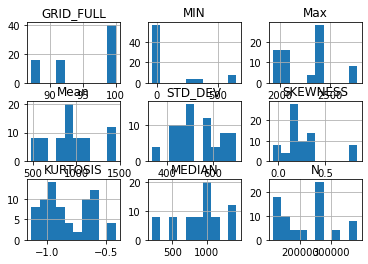

In [14]:
df_csv.hist()

<AxesSubplot:>

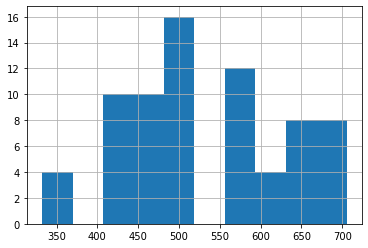

In [16]:
df_csv['STD_DEV'].hist()